In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from PIL import Image
from tqdm import tqdm
from skimage.feature import hog
from sklearn.cluster import KMeans

In [34]:
def load_dataset(set_name, labels=None, max_per_label=None, resize=None):
    np.random.seed(0)
    dataset_path = '../datasets/wbc/raw/{}'.format(set_name)
    print('Loading dataset from `{}`'.format(dataset_path))
    
    images, metadata = [], []
    if labels is None:
        labels = os.listdir(dataset_path)
    elif isinstance(labels, str):
        labels = [labels]
    elif not isinstance(labels, list):
        raise ValueError('labels must be a list of strings')

    for label in labels:
        label_path = f'{dataset_path}/{label}'
        fnames = os.listdir(label_path)
        if max_per_label is not None:
            count = min(max_per_label, len(fnames))
            fnames = np.random.choice(fnames, count, replace=False)
        
        df = []
        print('> Loading', label, 'class')
        for fname in tqdm(fnames):
            img_path = f'{label_path}/{fname}'
            data_dict = {'image_path': img_path, 'label': label}
            image = Image.open(img_path)
            if resize is not None:
                image = image.resize(resize)
            image = np.array(image)

            df.append(data_dict)
            images.append(image)

        df = pd.DataFrame(df)
        metadata.append(df)

    metadata = pd.concat(metadata).reset_index(drop=True)
    images = np.array(images)
    return images, metadata

In [35]:
with open('./kmeans_model_5.pk', 'rb') as f:
    kmeans_5 = pickle.load(f)

c:\Users\asus_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [57]:
def rgb_to_ggb(img, contrast = 1.7):
    image = img.copy()
    g_contrast = np.minimum(255, image[:, :, 1] * contrast)
    image[:, :, 1] = g_contrast
    image[:, :, 0] = g_contrast
    return image

def extract_hog_features(dataset, metadata, prep='plain', split_set='train', labels=None, **hog_kwargs):
    if labels is None:
        labels = sorted(metadata.label.unique())
    elif isinstance(labels, str):
        labels = [labels]
    elif not isinstance(labels, list):
        raise ValueError('labels must be a string or a list of strings')

    for label in labels:
        hog_features = []
        print(f'> Extracting HOG features for {split_set} set, {label} class')
        for img in tqdm(dataset[metadata.label == label]):
            ggb = img.copy()
            if prep == 'ggb':
                ggb = rgb_to_ggb(img)
            elif prep == 'segm':
                ggb = rgb_to_ggb(img)
                clusters = kmeans_5.predict(ggb.reshape(-1, 3))
                ggb = kmeans_5.cluster_centers_[clusters].reshape(img.shape)
                ggb = ggb.round().astype(np.uint8)

            fd = hog(ggb, channel_axis=2, **hog_kwargs)
            hog_features.append(fd)
        
        hog_features = np.array(hog_features)
        filename = f'../datasets/wbc/clean/hog_features_{prep}_{split_set}_{label}.npz'
        np.savez_compressed(filename, hog_features)

In [51]:
labels = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']

train_images, train_metadata = load_dataset(set_name='Train', labels=labels, resize=(64, 64))
test_images, test_metadata = load_dataset(set_name='TestA', labels=labels, resize=(64, 64))


Loading dataset from `../datasets/wbc/raw/Train`
> Loading Basophil class


100%|██████████| 212/212 [00:01<00:00, 136.51it/s]


> Loading Eosinophil class


100%|██████████| 744/744 [00:04<00:00, 184.44it/s]


> Loading Lymphocyte class


100%|██████████| 2427/2427 [00:13<00:00, 180.76it/s]


> Loading Monocyte class


100%|██████████| 561/561 [00:03<00:00, 174.95it/s]


> Loading Neutrophil class


100%|██████████| 6231/6231 [00:33<00:00, 184.04it/s]


Loading dataset from `../datasets/wbc/raw/TestA`
> Loading Basophil class


100%|██████████| 89/89 [00:00<00:00, 154.14it/s]


> Loading Eosinophil class


100%|██████████| 322/322 [00:01<00:00, 165.32it/s]


> Loading Lymphocyte class


100%|██████████| 1034/1034 [00:05<00:00, 202.62it/s]


> Loading Monocyte class


100%|██████████| 234/234 [00:01<00:00, 198.05it/s]


> Loading Neutrophil class


100%|██████████| 2660/2660 [00:13<00:00, 197.50it/s]


In [54]:
extract_hog_features(train_images, train_metadata, split_set='train', prep='plain')
extract_hog_features(test_images, test_metadata, split_set='test', prep='plain')

> Extracting HOG features for train set, Basophil class


100%|██████████| 212/212 [00:00<00:00, 364.56it/s]


> Extracting HOG features for train set, Eosinophil class


100%|██████████| 744/744 [00:01<00:00, 446.45it/s]


> Extracting HOG features for train set, Lymphocyte class


100%|██████████| 2427/2427 [00:05<00:00, 484.52it/s]


> Extracting HOG features for train set, Monocyte class


100%|██████████| 561/561 [00:01<00:00, 476.17it/s]


> Extracting HOG features for train set, Neutrophil class


100%|██████████| 6231/6231 [00:12<00:00, 495.67it/s]


> Extracting HOG features for test set, Basophil class


100%|██████████| 89/89 [00:00<00:00, 491.53it/s]


> Extracting HOG features for test set, Eosinophil class


100%|██████████| 322/322 [00:00<00:00, 428.78it/s]


> Extracting HOG features for test set, Lymphocyte class


100%|██████████| 1034/1034 [00:02<00:00, 477.71it/s]


> Extracting HOG features for test set, Monocyte class


100%|██████████| 234/234 [00:01<00:00, 159.39it/s]


> Extracting HOG features for test set, Neutrophil class


100%|██████████| 2660/2660 [00:13<00:00, 201.70it/s]


In [58]:
extract_hog_features(train_images, train_metadata, split_set='train', prep='ggb')
extract_hog_features(test_images, test_metadata, split_set='test', prep='ggb')

> Extracting HOG features for train set, Basophil class


100%|██████████| 212/212 [00:00<00:00, 482.48it/s]


> Extracting HOG features for train set, Eosinophil class


100%|██████████| 744/744 [00:01<00:00, 421.48it/s]


> Extracting HOG features for train set, Lymphocyte class


100%|██████████| 2427/2427 [00:05<00:00, 408.97it/s]


> Extracting HOG features for train set, Monocyte class


100%|██████████| 561/561 [00:01<00:00, 446.68it/s]


> Extracting HOG features for train set, Neutrophil class


100%|██████████| 6231/6231 [00:13<00:00, 465.85it/s]


> Extracting HOG features for test set, Basophil class


100%|██████████| 89/89 [00:00<00:00, 520.51it/s]


> Extracting HOG features for test set, Eosinophil class


100%|██████████| 322/322 [00:00<00:00, 371.49it/s]


> Extracting HOG features for test set, Lymphocyte class


100%|██████████| 1034/1034 [00:02<00:00, 487.91it/s]


> Extracting HOG features for test set, Monocyte class


100%|██████████| 234/234 [00:00<00:00, 440.12it/s]


> Extracting HOG features for test set, Neutrophil class


100%|██████████| 2660/2660 [00:05<00:00, 480.43it/s]


In [59]:
extract_hog_features(train_images, train_metadata, split_set='train', prep='segm')
extract_hog_features(test_images, test_metadata, split_set='test', prep='segm')

> Extracting HOG features for train set, Basophil class


100%|██████████| 212/212 [00:00<00:00, 241.35it/s]


> Extracting HOG features for train set, Eosinophil class


100%|██████████| 744/744 [00:03<00:00, 240.26it/s]


> Extracting HOG features for train set, Lymphocyte class


100%|██████████| 2427/2427 [00:09<00:00, 243.62it/s]


> Extracting HOG features for train set, Monocyte class


100%|██████████| 561/561 [00:02<00:00, 245.51it/s]


> Extracting HOG features for train set, Neutrophil class


100%|██████████| 6231/6231 [00:27<00:00, 225.32it/s]


> Extracting HOG features for test set, Basophil class


100%|██████████| 89/89 [00:00<00:00, 215.52it/s]


> Extracting HOG features for test set, Eosinophil class


100%|██████████| 322/322 [00:02<00:00, 153.31it/s]


> Extracting HOG features for test set, Lymphocyte class


100%|██████████| 1034/1034 [00:06<00:00, 166.86it/s]


> Extracting HOG features for test set, Monocyte class


100%|██████████| 234/234 [00:01<00:00, 186.12it/s]


> Extracting HOG features for test set, Neutrophil class


100%|██████████| 2660/2660 [00:12<00:00, 208.53it/s]


(2916,)


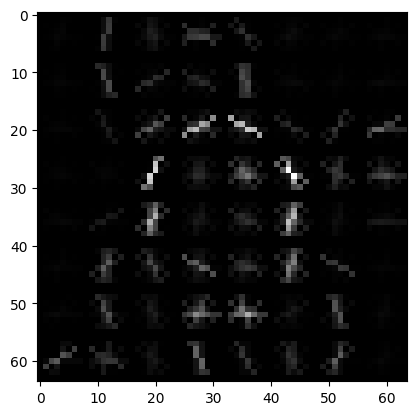

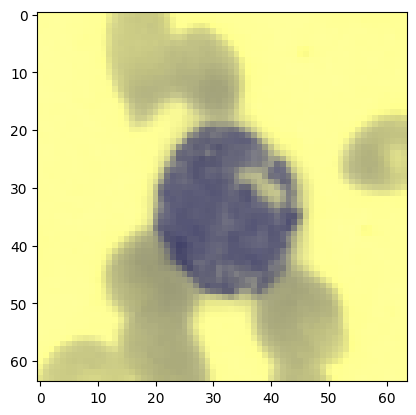

In [52]:
img = train_images[0]

ggb = rgb_to_ggb(img)
# clusters = kmeans_5.predict(ggb.reshape(-1, 3))
# ggb = kmeans_5.cluster_centers_[clusters].reshape(img.shape)
# ggb = ggb.round().astype(np.uint8)
fd, viz = hog(ggb, channel_axis=2, visualize=True)
print(fd.shape)
plt.imshow(viz, cmap='gray')
plt.show()
plt.imshow(ggb)
plt.show()

In [8]:
X = np.load('../datasets/wbc/clean/hog_features_train_Neutrophil.npz')['arr_0']
X.shape

(6231, 17424)

In [11]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                  train_images:  5.8 GiB
                             X: 828.3 MiB
                           ___: 28.2 MiB
                            _6: 28.2 MiB
                train_metadata:  1.7 MiB
                          tqdm:  2.0 KiB
                           _i4:  1.4 KiB
                           _i2:  1.3 KiB
                        KMeans:  1.0 KiB
                          _i11:  587.0 B
